In [1]:
!pip install torchinfo

# IMPORT LIBRARIES

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

# CONFIGURATION

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


# SEED VALUE

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# LOADING DATASET

In [5]:
data_dir = "/kaggle/input/fish-ra"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Tarabaim, Count: 2500
Class: Shol, Count: 2500
Class: Puti, Count: 2500
Class: DeshiPuti, Count: 2500
Class: Aair, Count: 2500
Class: Tengra, Count: 2500
Class: Pabda, Count: 2500
Class: Foli, Count: 2500
Class: Katla, Count: 2500
Class: Ilish, Count: 2500
Class: Taki, Count: 2500
Class: KalBaush, Count: 2500
Class: Chapila, Count: 2500
Class: Magur, Count: 2500
Class: Pangas, Count: 2500
Class: Mrigel, Count: 2500
Class: Telapiya, Count: 2500
Class: Koi, Count: 2500
Class: Boal, Count: 2500
Class: Rui, Count: 2500


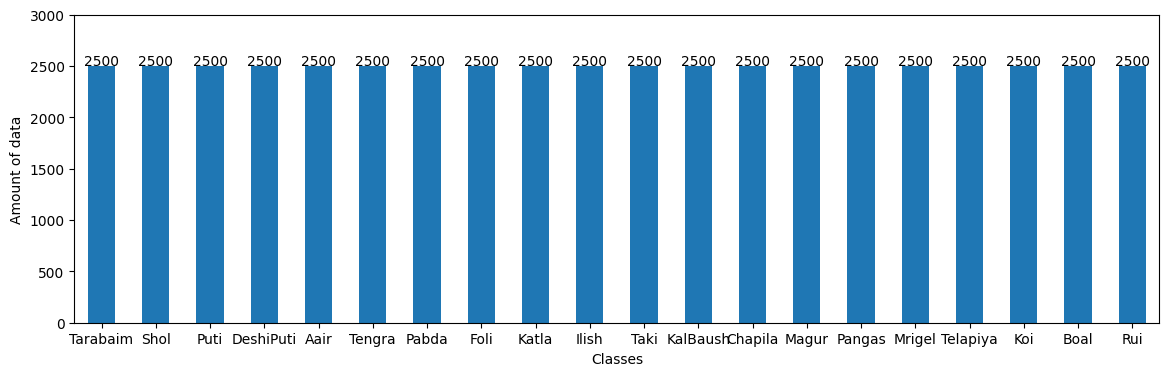

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

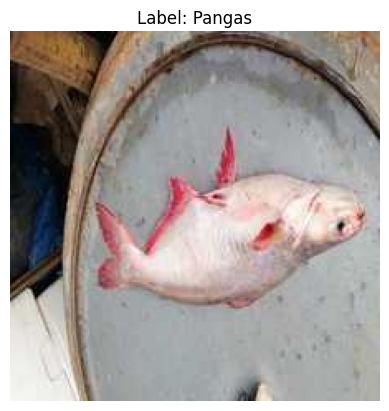

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# TRAINING-TESTING-VALIDATION (RATIO 70-15-15)

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  35000
Validation Data:  7500
Test Data:  7500
-------------------------------------------
Total amounts of data in the dataset:  50000


# DEVICE

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# CHECKPOINT

In [11]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# DATA CLASS, DATA LOADER, TRANSFORM

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])    
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# GoogleNet   

In [15]:
from torchvision.models import googlenet

total_class = 20     
learning_rate = 0.0001


model = googlenet(pretrained=True)


for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Linear(model.fc.in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


summary(model, input_size=(train_batch, 3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 192MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [32, 20]                  --
├─BasicConv2d: 1-1                       [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        (128)
├─MaxPool2d: 1-2                         [32, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [32, 64, 56, 56]          --
│    └─Conv2d: 2-3                       [32, 64, 56, 56]          (4,096)
│    └─BatchNorm2d: 2-4                  [32, 64, 56, 56]          (128)
├─BasicConv2d: 1-4                       [32, 192, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 192, 56, 56]         (110,592)
│    └─BatchNorm2d: 2-6                  [32, 192, 56, 56]         (384)
├─MaxPool2d: 1-5                         [32, 192, 28, 28]         --
├─Inception: 1-6                         [32, 256, 28, 28] 

# TRAINING

In [16]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        
    
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/100: 100%|██████████| 1094/1094 [01:35<00:00, 11.41it/s, acc=0.602, loss=2.09]

Training Loss: 2.086 Acc: 0.602


Validation Loss: 1.365 Acc: 0.821
Best model saved at epoch 1 with validation accuracy: 0.821


Epoch 2/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.17it/s, acc=0.808, loss=1.17]

Training Loss: 1.171 Acc: 0.808


Validation Loss: 0.860 Acc: 0.867
Best model saved at epoch 2 with validation accuracy: 0.867


Epoch 3/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.94it/s, acc=0.845, loss=0.843]

Training Loss: 0.843 Acc: 0.845


Validation Loss: 0.643 Acc: 0.891
Best model saved at epoch 3 with validation accuracy: 0.891


Epoch 4/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.94it/s, acc=0.868, loss=0.672]


Training Loss: 0.672 Acc: 0.868
Validation Loss: 0.525 Acc: 0.904
Best model saved at epoch 4 with validation accuracy: 0.904


Epoch 5/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.16it/s, acc=0.882, loss=0.571]


Training Loss: 0.571 Acc: 0.882
Validation Loss: 0.437 Acc: 0.919
Best model saved at epoch 5 with validation accuracy: 0.919


Epoch 6/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.08it/s, acc=0.892, loss=0.502]

Training Loss: 0.502 Acc: 0.892


Validation Loss: 0.380 Acc: 0.924
Best model saved at epoch 6 with validation accuracy: 0.924


Epoch 7/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.30it/s, acc=0.899, loss=0.45]

Training Loss: 0.450 Acc: 0.899


Validation Loss: 0.342 Acc: 0.930
Best model saved at epoch 7 with validation accuracy: 0.930


Epoch 8/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.17it/s, acc=0.904, loss=0.414]

Training Loss: 0.414 Acc: 0.904


Validation Loss: 0.313 Acc: 0.935
Best model saved at epoch 8 with validation accuracy: 0.935


Epoch 9/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.46it/s, acc=0.91, loss=0.384]

Training Loss: 0.384 Acc: 0.910


Validation Loss: 0.281 Acc: 0.940
Best model saved at epoch 9 with validation accuracy: 0.940


Epoch 10/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.33it/s, acc=0.913, loss=0.362]

Training Loss: 0.362 Acc: 0.913


Validation Loss: 0.265 Acc: 0.945
Best model saved at epoch 10 with validation accuracy: 0.945


Epoch 11/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.21it/s, acc=0.916, loss=0.344]

Training Loss: 0.344 Acc: 0.916


Validation Loss: 0.251 Acc: 0.946
Best model saved at epoch 11 with validation accuracy: 0.946


Epoch 12/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.23it/s, acc=0.92, loss=0.325]

Training Loss: 0.325 Acc: 0.920


Validation Loss: 0.238 Acc: 0.948
Best model saved at epoch 12 with validation accuracy: 0.948


Epoch 13/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.22it/s, acc=0.92, loss=0.313]


Training Loss: 0.313 Acc: 0.920
Validation Loss: 0.223 Acc: 0.952
Best model saved at epoch 13 with validation accuracy: 0.952


Epoch 14/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.26it/s, acc=0.924, loss=0.3]

Training Loss: 0.300 Acc: 0.924


Validation Loss: 0.210 Acc: 0.954
Best model saved at epoch 14 with validation accuracy: 0.954


Epoch 15/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.29it/s, acc=0.925, loss=0.291]

Training Loss: 0.291 Acc: 0.925


Validation Loss: 0.210 Acc: 0.951


Epoch 16/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.36it/s, acc=0.928, loss=0.281]

Training Loss: 0.281 Acc: 0.928


Validation Loss: 0.198 Acc: 0.952


Epoch 17/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.20it/s, acc=0.926, loss=0.277]

Training Loss: 0.277 Acc: 0.926


Validation Loss: 0.189 Acc: 0.955
Best model saved at epoch 17 with validation accuracy: 0.955


Epoch 18/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.08it/s, acc=0.931, loss=0.265]

Training Loss: 0.265 Acc: 0.931


Validation Loss: 0.185 Acc: 0.957
Best model saved at epoch 18 with validation accuracy: 0.957


Epoch 19/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.92it/s, acc=0.931, loss=0.259]

Training Loss: 0.259 Acc: 0.931


Validation Loss: 0.178 Acc: 0.958
Best model saved at epoch 19 with validation accuracy: 0.958


Epoch 20/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.10it/s, acc=0.931, loss=0.255]

Training Loss: 0.255 Acc: 0.931


Validation Loss: 0.174 Acc: 0.958
Best model saved at epoch 20 with validation accuracy: 0.958


Epoch 21/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.13it/s, acc=0.933, loss=0.248]

Training Loss: 0.248 Acc: 0.933


Validation Loss: 0.170 Acc: 0.959
Best model saved at epoch 21 with validation accuracy: 0.959


Epoch 22/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.29it/s, acc=0.934, loss=0.244]

Training Loss: 0.244 Acc: 0.934


Validation Loss: 0.166 Acc: 0.958


Epoch 23/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.18it/s, acc=0.935, loss=0.238]


Training Loss: 0.238 Acc: 0.935
Validation Loss: 0.161 Acc: 0.960
Best model saved at epoch 23 with validation accuracy: 0.960


Epoch 24/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.04it/s, acc=0.936, loss=0.234]


Training Loss: 0.234 Acc: 0.936
Validation Loss: 0.160 Acc: 0.959


Epoch 25/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.07it/s, acc=0.937, loss=0.229]

Training Loss: 0.229 Acc: 0.937


Validation Loss: 0.152 Acc: 0.963
Best model saved at epoch 25 with validation accuracy: 0.963


Epoch 26/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.47it/s, acc=0.938, loss=0.225]

Training Loss: 0.225 Acc: 0.938


Validation Loss: 0.153 Acc: 0.961


Epoch 27/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.23it/s, acc=0.936, loss=0.226]

Training Loss: 0.226 Acc: 0.936


Validation Loss: 0.153 Acc: 0.961


Epoch 28/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.19it/s, acc=0.936, loss=0.222]

Training Loss: 0.222 Acc: 0.936


Validation Loss: 0.147 Acc: 0.962


Epoch 29/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.08it/s, acc=0.94, loss=0.215]

Training Loss: 0.215 Acc: 0.940


Validation Loss: 0.143 Acc: 0.965
Best model saved at epoch 29 with validation accuracy: 0.965


Epoch 30/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.67it/s, acc=0.939, loss=0.214]

Training Loss: 0.214 Acc: 0.939


Validation Loss: 0.141 Acc: 0.963


Epoch 31/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.05it/s, acc=0.94, loss=0.211]

Training Loss: 0.211 Acc: 0.940


Validation Loss: 0.140 Acc: 0.963


Epoch 32/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.30it/s, acc=0.942, loss=0.207]

Training Loss: 0.207 Acc: 0.942


Validation Loss: 0.137 Acc: 0.964


Epoch 33/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.13it/s, acc=0.941, loss=0.206]

Training Loss: 0.206 Acc: 0.941


Validation Loss: 0.135 Acc: 0.963


Epoch 34/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.16it/s, acc=0.941, loss=0.205]


Training Loss: 0.205 Acc: 0.941
Validation Loss: 0.133 Acc: 0.966
Best model saved at epoch 34 with validation accuracy: 0.966


Epoch 35/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.19it/s, acc=0.94, loss=0.205]

Training Loss: 0.205 Acc: 0.940


Validation Loss: 0.131 Acc: 0.965


Epoch 36/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.18it/s, acc=0.942, loss=0.201]

Training Loss: 0.201 Acc: 0.942


Validation Loss: 0.128 Acc: 0.966
Best model saved at epoch 36 with validation accuracy: 0.966


Epoch 37/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.82it/s, acc=0.942, loss=0.199]

Training Loss: 0.199 Acc: 0.942


Validation Loss: 0.129 Acc: 0.965


Epoch 38/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.36it/s, acc=0.943, loss=0.196]

Training Loss: 0.196 Acc: 0.943


Validation Loss: 0.125 Acc: 0.968
Best model saved at epoch 38 with validation accuracy: 0.968


Epoch 39/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.29it/s, acc=0.942, loss=0.197]


Training Loss: 0.197 Acc: 0.942
Validation Loss: 0.129 Acc: 0.965


Epoch 40/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.30it/s, acc=0.942, loss=0.197]

Training Loss: 0.197 Acc: 0.942


Validation Loss: 0.123 Acc: 0.967


Epoch 41/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.48it/s, acc=0.941, loss=0.194]

Training Loss: 0.194 Acc: 0.941


Validation Loss: 0.124 Acc: 0.966


Epoch 42/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.04it/s, acc=0.943, loss=0.194]

Training Loss: 0.194 Acc: 0.943


Validation Loss: 0.123 Acc: 0.966


Epoch 43/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.36it/s, acc=0.943, loss=0.192]

Training Loss: 0.192 Acc: 0.943


Validation Loss: 0.119 Acc: 0.969
Best model saved at epoch 43 with validation accuracy: 0.969


Epoch 44/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.47it/s, acc=0.944, loss=0.19]

Training Loss: 0.190 Acc: 0.944


Validation Loss: 0.118 Acc: 0.968


Epoch 45/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.38it/s, acc=0.944, loss=0.186]

Training Loss: 0.186 Acc: 0.944


Validation Loss: 0.118 Acc: 0.967


Epoch 46/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.07it/s, acc=0.945, loss=0.184]


Training Loss: 0.184 Acc: 0.945
Validation Loss: 0.119 Acc: 0.967


Epoch 47/100: 100%|██████████| 1094/1094 [00:52<00:00, 21.03it/s, acc=0.943, loss=0.189]

Training Loss: 0.189 Acc: 0.943


Validation Loss: 0.116 Acc: 0.968


Epoch 48/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.15it/s, acc=0.944, loss=0.185]


Training Loss: 0.185 Acc: 0.944
Validation Loss: 0.121 Acc: 0.965


Epoch 49/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.41it/s, acc=0.946, loss=0.183]

Training Loss: 0.183 Acc: 0.946


Validation Loss: 0.115 Acc: 0.969
Best model saved at epoch 49 with validation accuracy: 0.969


Epoch 50/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.36it/s, acc=0.945, loss=0.182]


Training Loss: 0.182 Acc: 0.945
Validation Loss: 0.114 Acc: 0.967


Epoch 51/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.15it/s, acc=0.946, loss=0.179]

Training Loss: 0.179 Acc: 0.946


Validation Loss: 0.111 Acc: 0.969
Best model saved at epoch 51 with validation accuracy: 0.969


Epoch 52/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.91it/s, acc=0.948, loss=0.179]

Training Loss: 0.179 Acc: 0.948


Validation Loss: 0.113 Acc: 0.969
Best model saved at epoch 52 with validation accuracy: 0.969


Epoch 53/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.79it/s, acc=0.947, loss=0.179]

Training Loss: 0.179 Acc: 0.947


Validation Loss: 0.112 Acc: 0.969
Best model saved at epoch 53 with validation accuracy: 0.969


Epoch 54/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.91it/s, acc=0.945, loss=0.18]

Training Loss: 0.180 Acc: 0.945


Validation Loss: 0.112 Acc: 0.969


Epoch 55/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.25it/s, acc=0.946, loss=0.178]

Training Loss: 0.178 Acc: 0.946


Validation Loss: 0.112 Acc: 0.968


Epoch 56/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.07it/s, acc=0.946, loss=0.178]

Training Loss: 0.178 Acc: 0.946


Validation Loss: 0.108 Acc: 0.970
Best model saved at epoch 56 with validation accuracy: 0.970


Epoch 57/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.33it/s, acc=0.946, loss=0.174]

Training Loss: 0.174 Acc: 0.946


Validation Loss: 0.110 Acc: 0.968


Epoch 58/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.06it/s, acc=0.945, loss=0.176]

Training Loss: 0.176 Acc: 0.945


Validation Loss: 0.107 Acc: 0.969


Epoch 59/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.16it/s, acc=0.945, loss=0.174]

Training Loss: 0.174 Acc: 0.945


Validation Loss: 0.112 Acc: 0.968


Epoch 60/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.04it/s, acc=0.946, loss=0.175]

Training Loss: 0.175 Acc: 0.946


Validation Loss: 0.106 Acc: 0.969


Epoch 61/100: 100%|██████████| 1094/1094 [00:53<00:00, 20.64it/s, acc=0.946, loss=0.174]

Training Loss: 0.174 Acc: 0.946


Validation Loss: 0.107 Acc: 0.970


Epoch 62/100: 100%|██████████| 1094/1094 [00:54<00:00, 20.14it/s, acc=0.947, loss=0.171]

Training Loss: 0.171 Acc: 0.947


Validation Loss: 0.103 Acc: 0.971
Best model saved at epoch 62 with validation accuracy: 0.971


Epoch 63/100: 100%|██████████| 1094/1094 [00:52<00:00, 21.02it/s, acc=0.948, loss=0.169]

Training Loss: 0.169 Acc: 0.948


Validation Loss: 0.104 Acc: 0.970


Epoch 64/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.89it/s, acc=0.947, loss=0.17]


Training Loss: 0.170 Acc: 0.947
Validation Loss: 0.102 Acc: 0.971
Best model saved at epoch 64 with validation accuracy: 0.971


Epoch 65/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.04it/s, acc=0.947, loss=0.174]

Training Loss: 0.174 Acc: 0.947


Validation Loss: 0.101 Acc: 0.972
Best model saved at epoch 65 with validation accuracy: 0.972


Epoch 66/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.82it/s, acc=0.948, loss=0.167]

Training Loss: 0.167 Acc: 0.948


Validation Loss: 0.104 Acc: 0.971


Epoch 67/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.77it/s, acc=0.948, loss=0.168]

Training Loss: 0.168 Acc: 0.948


Validation Loss: 0.102 Acc: 0.970


Epoch 68/100: 100%|██████████| 1094/1094 [00:52<00:00, 21.01it/s, acc=0.948, loss=0.169]

Training Loss: 0.169 Acc: 0.948


Validation Loss: 0.102 Acc: 0.970


Epoch 69/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.78it/s, acc=0.948, loss=0.166]

Training Loss: 0.166 Acc: 0.948


Validation Loss: 0.102 Acc: 0.970


Epoch 70/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.93it/s, acc=0.949, loss=0.166]

Training Loss: 0.166 Acc: 0.949


Validation Loss: 0.101 Acc: 0.971


Epoch 71/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.55it/s, acc=0.948, loss=0.166]

Training Loss: 0.166 Acc: 0.948


Validation Loss: 0.099 Acc: 0.971


Epoch 72/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.17it/s, acc=0.948, loss=0.166]


Training Loss: 0.166 Acc: 0.948
Validation Loss: 0.100 Acc: 0.971


Epoch 73/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.12it/s, acc=0.949, loss=0.164]

Training Loss: 0.164 Acc: 0.949


Validation Loss: 0.097 Acc: 0.974
Best model saved at epoch 73 with validation accuracy: 0.974


Epoch 74/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.07it/s, acc=0.949, loss=0.162]

Training Loss: 0.162 Acc: 0.949


Validation Loss: 0.098 Acc: 0.972


Epoch 75/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.65it/s, acc=0.948, loss=0.166]


Training Loss: 0.166 Acc: 0.948
Validation Loss: 0.098 Acc: 0.971


Epoch 76/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.27it/s, acc=0.948, loss=0.165]


Training Loss: 0.165 Acc: 0.948
Validation Loss: 0.096 Acc: 0.972


Epoch 77/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.88it/s, acc=0.949, loss=0.164]

Training Loss: 0.164 Acc: 0.949


Validation Loss: 0.096 Acc: 0.972


Epoch 78/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.42it/s, acc=0.948, loss=0.163]

Training Loss: 0.163 Acc: 0.948


Validation Loss: 0.096 Acc: 0.973


Epoch 79/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.91it/s, acc=0.949, loss=0.162]


Training Loss: 0.162 Acc: 0.949
Validation Loss: 0.093 Acc: 0.973


Epoch 80/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.37it/s, acc=0.949, loss=0.162]


Training Loss: 0.162 Acc: 0.949
Validation Loss: 0.095 Acc: 0.973


Epoch 81/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.97it/s, acc=0.95, loss=0.162]

Training Loss: 0.162 Acc: 0.950


Validation Loss: 0.098 Acc: 0.971


Epoch 82/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.33it/s, acc=0.949, loss=0.162]

Training Loss: 0.162 Acc: 0.949


Validation Loss: 0.095 Acc: 0.971


Epoch 83/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.20it/s, acc=0.95, loss=0.162]

Training Loss: 0.162 Acc: 0.950


Validation Loss: 0.093 Acc: 0.973


Epoch 84/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.31it/s, acc=0.949, loss=0.16]

Training Loss: 0.160 Acc: 0.949


Validation Loss: 0.095 Acc: 0.973


Epoch 85/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.30it/s, acc=0.951, loss=0.161]

Training Loss: 0.161 Acc: 0.951


Validation Loss: 0.093 Acc: 0.973


Epoch 86/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.48it/s, acc=0.949, loss=0.159]

Training Loss: 0.159 Acc: 0.949


Validation Loss: 0.095 Acc: 0.973


Epoch 87/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.10it/s, acc=0.95, loss=0.158]

Training Loss: 0.158 Acc: 0.950


Validation Loss: 0.091 Acc: 0.974
Best model saved at epoch 87 with validation accuracy: 0.974


Epoch 88/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.44it/s, acc=0.948, loss=0.161]

Training Loss: 0.161 Acc: 0.948


Validation Loss: 0.093 Acc: 0.974


Epoch 89/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.36it/s, acc=0.95, loss=0.158]

Training Loss: 0.158 Acc: 0.950


Validation Loss: 0.093 Acc: 0.972


Epoch 90/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.62it/s, acc=0.949, loss=0.158]

Training Loss: 0.158 Acc: 0.949


Validation Loss: 0.092 Acc: 0.973


Epoch 91/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.46it/s, acc=0.951, loss=0.157]

Training Loss: 0.157 Acc: 0.951


Validation Loss: 0.091 Acc: 0.974


Epoch 92/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.82it/s, acc=0.95, loss=0.158]


Training Loss: 0.158 Acc: 0.950
Validation Loss: 0.090 Acc: 0.973


Epoch 93/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.56it/s, acc=0.949, loss=0.157]

Training Loss: 0.157 Acc: 0.949


Validation Loss: 0.095 Acc: 0.971


Epoch 94/100: 100%|██████████| 1094/1094 [00:52<00:00, 21.04it/s, acc=0.949, loss=0.159]

Training Loss: 0.159 Acc: 0.949


Validation Loss: 0.090 Acc: 0.975
Best model saved at epoch 94 with validation accuracy: 0.975


Epoch 95/100: 100%|██████████| 1094/1094 [00:50<00:00, 21.55it/s, acc=0.948, loss=0.16]

Training Loss: 0.160 Acc: 0.948


Validation Loss: 0.091 Acc: 0.974


Epoch 96/100: 100%|██████████| 1094/1094 [00:52<00:00, 21.04it/s, acc=0.952, loss=0.155]

Training Loss: 0.155 Acc: 0.952


Validation Loss: 0.089 Acc: 0.974


Epoch 97/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.27it/s, acc=0.95, loss=0.155]

Training Loss: 0.155 Acc: 0.950


Validation Loss: 0.090 Acc: 0.973


Epoch 98/100: 100%|██████████| 1094/1094 [00:52<00:00, 20.92it/s, acc=0.949, loss=0.157]


Training Loss: 0.157 Acc: 0.949
Validation Loss: 0.090 Acc: 0.973


Epoch 99/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.10it/s, acc=0.951, loss=0.155]

Training Loss: 0.155 Acc: 0.951


Validation Loss: 0.090 Acc: 0.975


Epoch 100/100: 100%|██████████| 1094/1094 [00:51<00:00, 21.16it/s, acc=0.951, loss=0.154]

Training Loss: 0.154 Acc: 0.951


Validation Loss: 0.091 Acc: 0.974
Training Time: 6692.92 seconds ---> 111.55 minutes


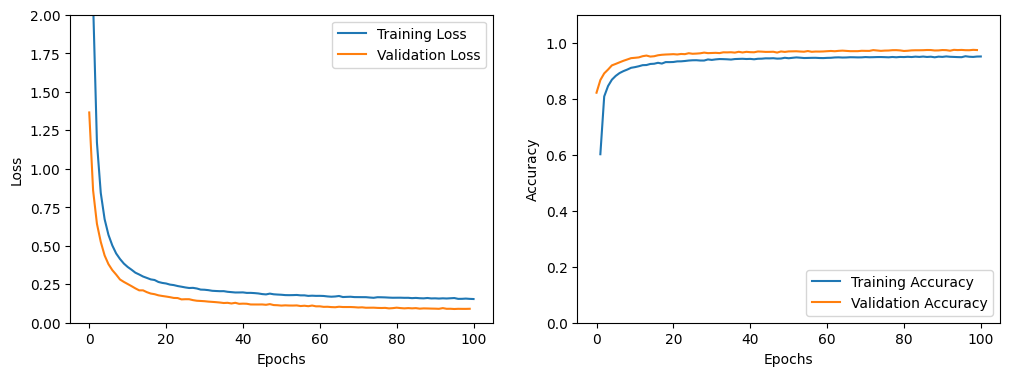

In [17]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

# EVOLUTION

In [18]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [19]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.5f}")

Best model (from epoch 94) - Validation Loss: 0.090, Validation Accuracy: 0.97453


In [20]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.972
Test Time: 32.07 seconds ---> 0.53 minutes


In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       375
           1       0.96      0.96      0.96       375
           2       0.99      0.99      0.99       375
           3       0.99      0.99      0.99       375
           4       0.99      0.99      0.99       375
           5       0.99      0.98      0.98       375
           6       0.95      0.98      0.96       375
           7       0.95      0.95      0.95       375
           8       0.98      0.99      0.99       375
           9       1.00      1.00      1.00       375
          10       0.98      0.98      0.98       375
          11       0.97      0.98      0.98       375
          12       0.99      0.99      0.99       375
          13       0.98      0.98      0.98       375
          14       0.96      0.92      0.94       375
          15       0.96      0.95      0.96       375
          16       0.93      0.93      0.93       375
    